In [35]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math
import re

import lsst.daf.base as dafBase
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import CatalogCalculationTask

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

In [8]:
# List of visits to be considered
#visits = [8]
#visits = [849375, 850587]
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal_2/"
# Reference visit
ref = 802227

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
#ccd = [0, 1, 7, 8, 27, 28, 33, 35]
ccd = range(0,36)
#ccd = [21, 22, 27, 28]
#ccd = [14]
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_CircularApertureFlux_4_5_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler(DATADIR+"/jointcal_test_2")
butlerV = dafPersist.Butler(DATADIR+"/vanilla_12days")

In [16]:
def detect_sources(exposure):
    threshold = 6
    doSmooth=True
    schema = afwTable.SourceTable.makeMinimalSchema()


    algMetadata = dafBase.PropertyList()

    config = SourceDetectionTask.ConfigClass()
    #config.thresholdPolarity = "both"
    config.thresholdValue = threshold
    config.reEstimateBackground = False
    #config.thresholdType = "pixel_stdev"

    detectionTask = SourceDetectionTask(config=config, schema=schema)

    measurement = SingleFrameMeasurementTask
    config = measurement.ConfigClass()

    measurement = measurement(schema, config=config, algMetadata=algMetadata)

    deblend = SourceDeblendTask
    config = SourceDeblendTask.ConfigClass()
    deblend = deblend(schema)

    calculation = CatalogCalculationTask
    config = CatalogCalculationTask.ConfigClass()
    config.plugins.names.clear()
    config.plugins.names.add("base_ClassificationExtendedness")

    calculation = calculation(schema, config=config)

    table = afwTable.SourceTable.make(schema)

    results = detectionTask.run(table=table, exposure=exposure , doSmooth=doSmooth )

    sourcesCat = results.sources

    deblend.run(exposure, sourcesCat)

    measurement.run(measCat=sourcesCat, exposure=exposure)
    calculation.run(sourcesCat)
    return sourcesCat


In [3]:
for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    if butler.datasetExists('src', dataid):
    
        oldSrc = butler.get('src', dataid, immediate=True)
        print c, len(oldSrc)
        if indx == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type="I", doc="CCD number")

            #create the new extented source catalog 
            srcRef = afwTable.SourceCatalog(newSchema)

        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

0 2670
1 3119
2 3419
3 3094
4 3215
5 3425
6 2980
7 3209
8 2918
9 3406
10 3073
11 3077
12 2809
13 2822
14 3033
15 3513
16 3178
17 2560
18 2985
19 2849
20 2965
21 2843
22 3007
23 3075
24 2908
25 2824
26 2681
27 2692
28 2957
29 2738
30 2979
31 3207
32 2904
33 3213
34 2970
35 2924
Ref... 108241


In [ ]:
jointcal_dccat = None

for p in patches:
    if butler.datasetExists('deepCoadd', {'patch':p, 'filter':filter, 'tract':tract}):
        deepCoadd = butler.get('deepCoadd', {'patch':p, 'filter':filter, 'tract':tract})
        deepSrcs = detect_sources(deepCoadd)
        if jointcal_dccat is None:
            jointcal_dccat = afwTable.SourceCatalog(deepSrcs.table)

        jointcal_dccat.extend(deepSrcs)
        

In [ ]:
vanilla_dccat = None

for p in patches:
    if butlerV.datasetExists('deepCoadd', {'patch':p, 'filter':filter, 'tract':tract}):
        deepCoadd = butlerV.get('deepCoadd', {'patch':p, 'filter':filter, 'tract':tract})
        deepSrcs = detect_sources(deepCoadd)
        if vanilla_dccat is None:
            vanilla_dccat = afwTable.SourceCatalog(deepSrcs.table)

        vanilla_dccat.extend(deepSrcs)
        

In [25]:
print len(jointcal_dccat), len(vanilla_dccat)

207544 208193


In [26]:
matches_jointcal = afwTable.matchRaDec(srcRef, jointcal_dccat, afwGeom.Angle(1./3600., afwGeom.degrees))
matches_vanilla = afwTable.matchRaDec(srcRef, vanilla_dccat, afwGeom.Angle(1./3600., afwGeom.degrees))

In [59]:
distances_joint = []
for m in matches_jointcal:
    mref = m.first
    mjoint = m.second
    
    if mjoint["base_ClassificationExtendedness_value"]>0.5:
        distances_joint.append(afwGeom.radToMas(m.distance))
        

In [60]:
distances_vanilla = []
for m in matches_vanilla:
    mref = m.first
    mvanilla = m.second
    
    if mvanilla["base_ClassificationExtendedness_value"]>0.5:
        distances_vanilla.append(afwGeom.radToMas(m.distance))
        

In [61]:
 np.median(distances_joint)

74.720365283887233

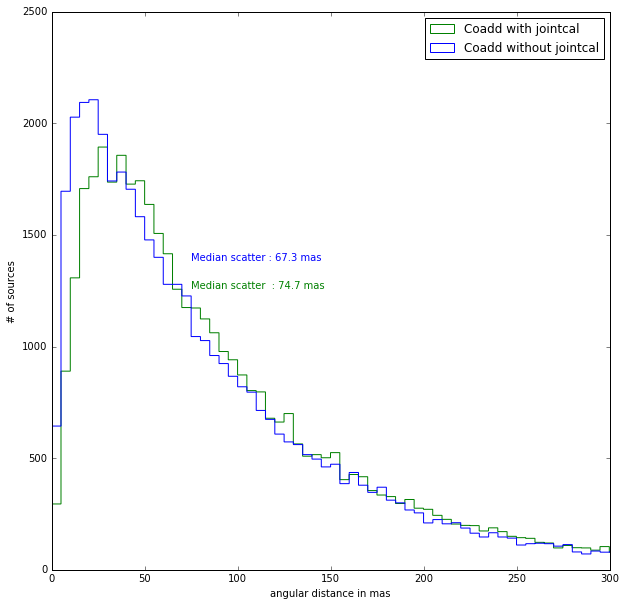

In [66]:
#plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(distances_joint, bins=200, histtype="step", label="Coadd with jointcal", color="green")
ax0.hist(distances_vanilla, bins=200, histtype="step", label="Coadd without jointcal", color="blue")

ax0.legend()
ax0.set_xlim([0,300])
#ax0.text("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),(0.4,0.8), xycoords="figure fraction")
ax0.text(0.25, 0.5,"Median scatter  : %0.1f mas"%( np.median(distances_joint)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='green',)
ax0.text(0.25, 0.55,"Median scatter : %0.1f mas"%( np.median(distances_vanilla)), verticalalignment='bottom', 
        transform=ax0.transAxes, color='blue',)

ax0.set_xlabel("angular distance in mas")
ax0.set_ylabel("# of sources")

plt.show()

#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))
#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))
